# Environment Comparison

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from analysis import Analysis2Fits, Analysis, MultiRunAnalysis, MultiAnalysis2Fits
from experiment import Experiment
from utils import eval_position, ENV2_EVAL_BATCHES
from scipy.stats import norm
from gc import collect


data_path = "../data"
save_path = "../figs"

In [2]:
a2fs = [Analysis2Fits(data_path, '2fits'), Analysis2Fits(data_path, 'fake_cells')]

### Losses

In [3]:
losses = [a2f.get_pos_losses() for a2f in a2fs]

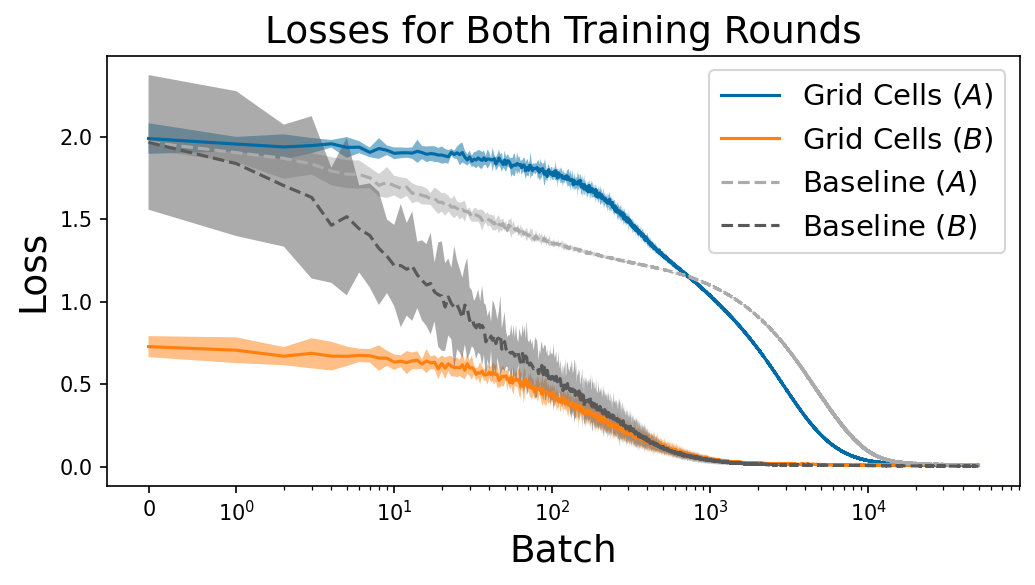

In [15]:
plt.figure(figsize=(7, 4), dpi=150)

i = 50000
for loss, label, f in zip(losses, ['Grid Cells', 'Baseline'], ['-', '--']):
    for j, env in enumerate(['A', 'B']):
        mean, std = loss.mean(1)[j, :i], loss.std(1)[j, :i] * 2
        plt.plot(mean, f, label=f'{label} (${env}$)')
        plt.fill_between(range(i), mean + std, mean - std, alpha=0.5)

plt.xscale('symlog', linthresh=1, subs=range(2, 10), linscale=0.5)
plt.legend(fontsize=14)
plt.xlabel('Batch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title("Losses for Both Training Rounds", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'loss_env2.png'))
plt.show()

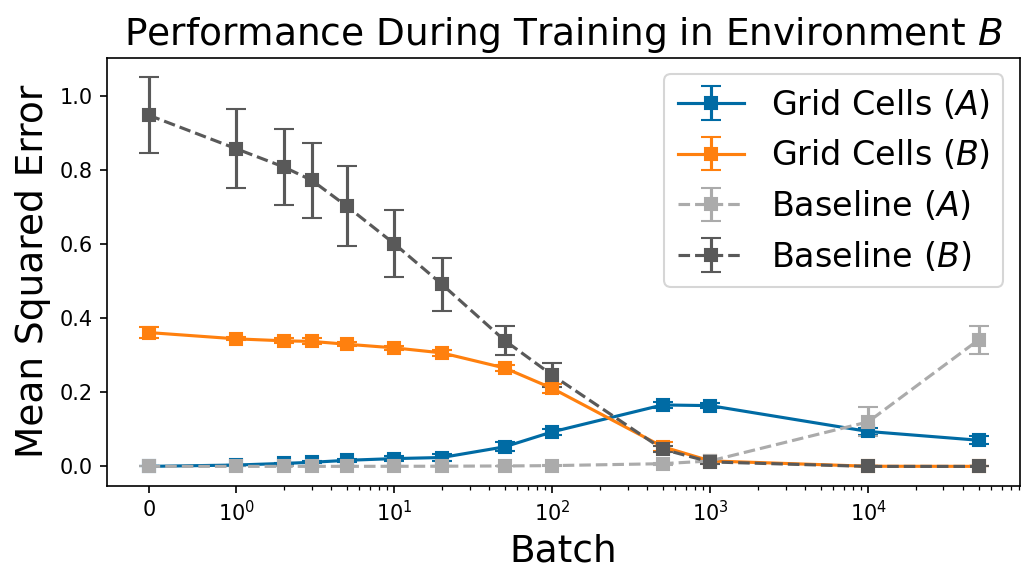

In [5]:
plt.figure(figsize=(7, 4), dpi=150)

for a2f, f in zip(a2fs, ['s-', 's--']):
    cis = a2f.evals.std(0) * norm.ppf(0.995) / np.sqrt(a2f.evals.shape[0])
    for mean, ci in zip(a2f.evals.mean(0)[::-1], cis[::-1]):
        plt.errorbar(ENV2_EVAL_BATCHES, mean, yerr=ci, capsize=5, fmt=f)

plt.xscale('symlog', linthresh=1, subs=range(2, 10), linscale=0.5)
plt.legend(["Grid Cells ($A$)", "Grid Cells ($B$)", "Baseline ($A$)", "Baseline ($B$)"], fontsize=16)
plt.xlabel('Batch', fontsize=18)
plt.ylabel('Mean Squared Error', fontsize=18)
plt.title("Performance During Training in Environment $B$", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'validation_env2.png'))
plt.show()

### Remapping

In [6]:
exp_names = ['2fits50b', '2fits500b', '2fits5000b', '2fits']
batches = [50, 500, 5000, 50000]

df = MultiAnalysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.rename(index={i: b for i, b in zip(exp_names, batches)})

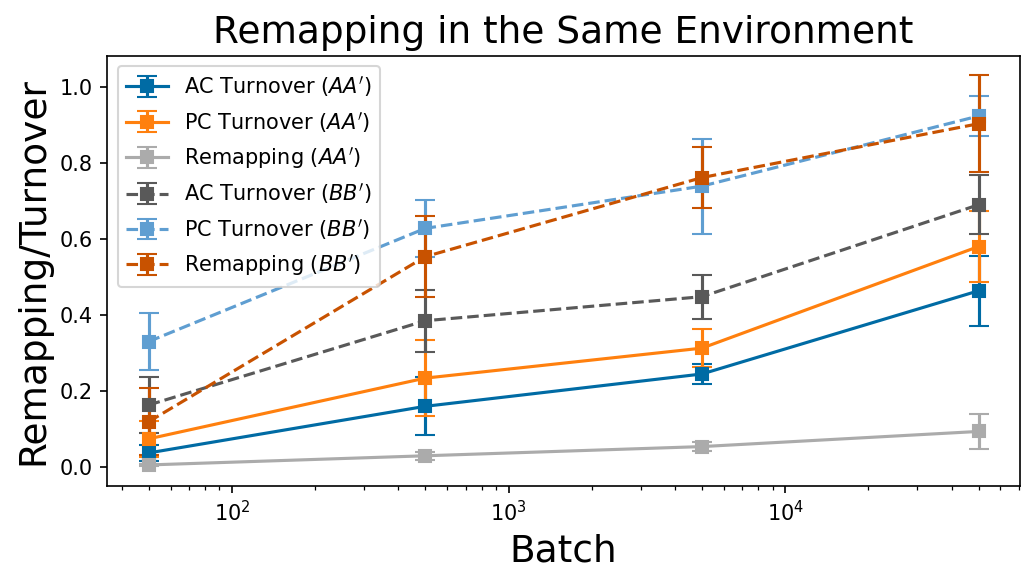

In [7]:
plt.figure(figsize=(7, 4), dpi=150)

group = df.groupby(level=(0, 2), sort=False)
means = group.mean().unstack(0).T.groupby(level=0)
stds = group.std().unstack(0).T
cis = stds * norm.ppf(0.995) / np.sqrt(df.index.get_level_values(1).unique().size)

fmts = {"1_1'": 's-', "2_2'": 's--'}
for (l, remap), (_, ci) in zip(means, cis.groupby(level=0)):
    remap = remap.droplevel(0).T.iterrows()
    ci = ci.droplevel(0).T.iterrows()
    for (stat, row), (_, s) in zip(remap, ci):
        plt.errorbar(batches, row, yerr=s, capsize=5, label=stat, fmt=fmts[l])
plt.xscale('log')

plt.legend(["AC Turnover ($AA'$)", "PC Turnover ($AA'$)",
            "Remapping ($AA'$)", "AC Turnover ($BB'$)",
            "PC Turnover ($BB'$)", "Remapping ($BB'$)"], fontsize=10)
plt.xlabel('Batch', fontsize=18)
plt.ylabel('Remapping/Turnover', fontsize=18)
plt.title("Remapping in the Same Environment", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'remaps_env2.png'))
plt.show()

### All Metrics

In [8]:
def get_means_and_stds(df):
    env1 = df.loc[:, 1, :].groupby(level=-1)
    env2 = df.loc[:, 2, :].groupby(level=-1)
    
    means = pd.concat([env1.mean(), env2.mean()], keys=['env1', 'env2'])
    stds = pd.concat([env1.std(), env2.std()], keys=['env1', 'env2'])
    
    return means, stds

m, s = get_means_and_stds(a2f.df1)
means, stds = [m], [s]

for name in exp_names:
    a2f = Analysis2Fits(data_path, name)
    m, s = get_means_and_stds(a2f.df2)

    means.append(m)
    stds.append(s)
    
means = pd.concat(means, keys=[0, *batches])
stds = pd.concat(stds, keys=[0, *batches])

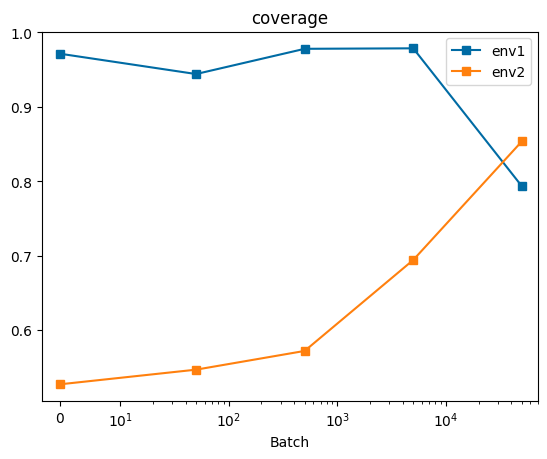

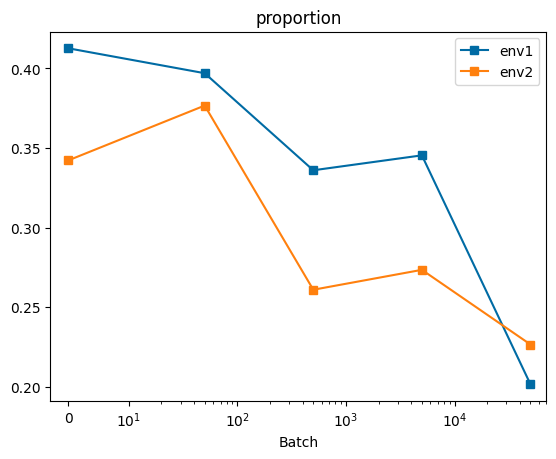

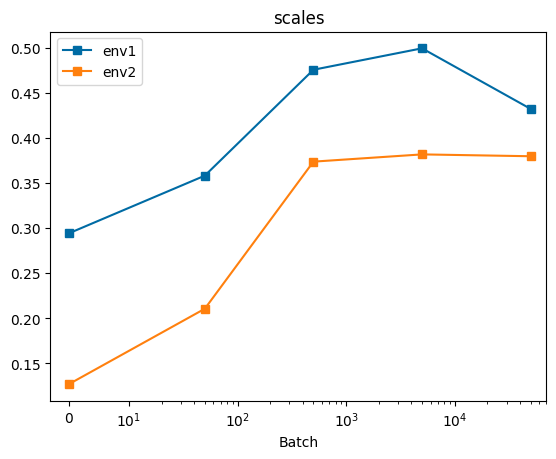

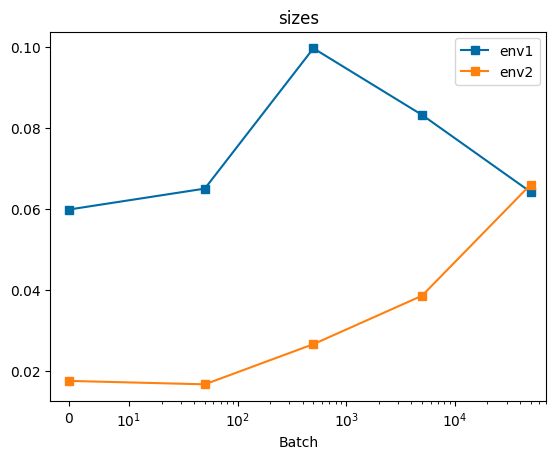

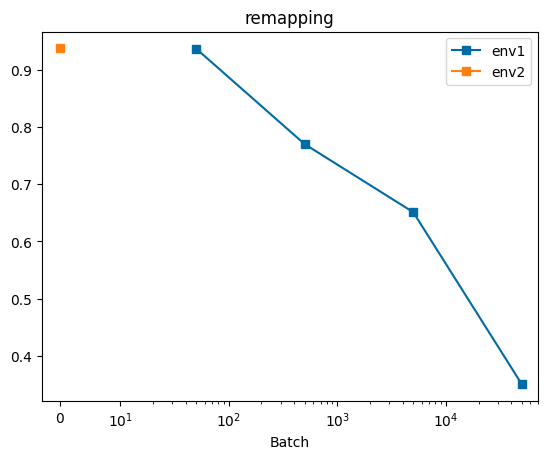

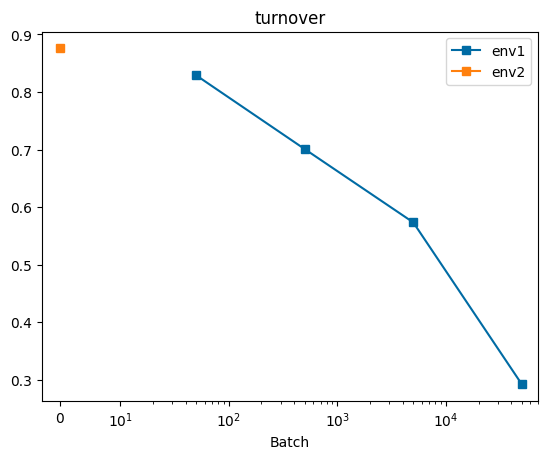

In [9]:
stats = ['coverage', 'proportion', 'scales', 'sizes', 'remapping', 'turnover']

for stat in stats:
    means.loc[:, :, stat].place.unstack(1).plot(marker='s')
    plt.xscale('symlog', linthresh=10, subs=range(2, 10), linscale=0.5)
    plt.xlim(-3, batches[-1]+20000)
    plt.xlabel("Batch")
    plt.title(stat)
    plt.show()

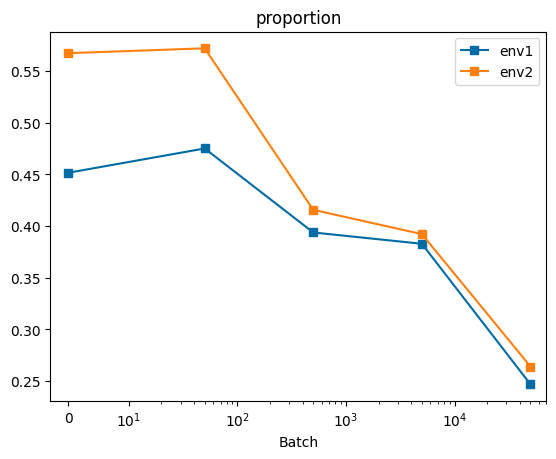

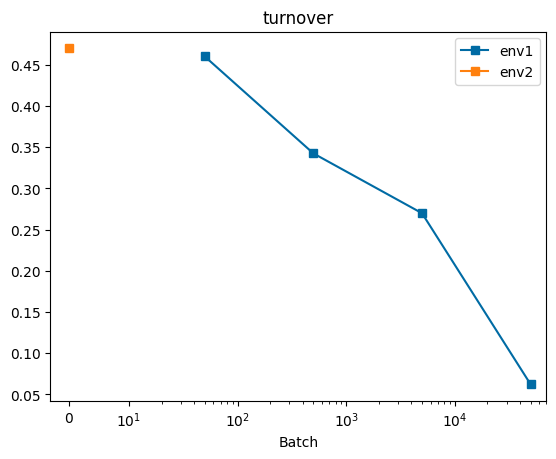

In [10]:
stats = ['proportion', 'turnover']

for stat in stats:
    means.loc[:, :, stat].active.unstack(1).plot(marker='s')
    plt.xscale('symlog', linthresh=10, subs=range(2, 10), linscale=0.5)
    plt.xlim(-3, batches[-1]+20000)
    plt.xlabel("Batch")
    plt.title(stat)
    plt.show()